# 1、处理数据

In [1]:
import pandas as pd
import tensorflow as tf
data_file = '../../代码/推荐算法-FM/data/train.txt'
df = pd.read_csv(data_file, engine="python")
df[:3]

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN


In [2]:
dense_features = ["I" + str(i) for i in range(1,14)]
sparse_features = ["C" + str(i) for i in range(1,27)]
feature_columns = dense_features + sparse_features
#feature_columns

In [3]:
df[sparse_features] = df[sparse_features].fillna('-1')
df[dense_features] = df[dense_features].fillna(0)

In [4]:
#归一化
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df[dense_features] = MinMaxScaler().fit_transform(df[dense_features])
for s_f in sparse_features:
    df[s_f] = LabelEncoder().fit_transform(df[s_f])
    
#切分数据集
X=df.drop(['label'], axis = 1)
Y=df['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train = [X_train[i] for i in feature_columns]
X_test = [X_test[i] for i in feature_columns]
len(X_train)

39

In [5]:
from collections import namedtuple
#准备特征的配置
embedding_dim = 8
DenseFeat = namedtuple('DenseFeat', ['name'])
SparseFeat = namedtuple('SparseFeat', ['name','input_dim', 'output_idm', 'trainable'])
dense_feature_columns = [DenseFeat(x) for x in dense_features]
sparse_feature_columns = [SparseFeat(x, df[x].nunique(), embedding_dim, True) for x in sparse_features]
feature_columns = dense_feature_columns + sparse_feature_columns
#feature_columns

# 2、定义层与模型

In [6]:
import numpy as np 
class CINLayer(tf.keras.layers.Layer):
    def __init__(self, feature_num_0, feature_num_pre,feature_num, k,**kwargs):
        super(CINLayer,self).__init__()
        self.feature_num_0 = feature_num_0
        self.feature_num_pre = feature_num_pre
        self.feature_num = feature_num
        self.k = k
        self.w = self.add_weight(name='w_'+self.name, 
                                 shape=(self.feature_num_0*self.feature_num_pre, feature_num), 
                                 trainable=True,
                                 initializer=tf.initializers.glorot_uniform(),
                                 regularizer=tf.keras.regularizers.l1_l2(1e-5))
        self.Conv1D_layer = tf.keras.layers.Conv1D(self.feature_num, 1, 
                                        activation='relu',
                                        input_shape=[self.k,self.feature_num_0*self.feature_num_pre])
    def call(self, inputs):
        # inputs: [None, feature_num_0 + feature_num_pre, k], 只有SparseFeature 
        if (inputs.shape[-1] != self.k):
            raise ValueError('last dim should be {}'.format(self.k))
        x = tf.split(inputs, self.feature_num_0 + self.feature_num_pre, axis=1) 
        #x (self.feature_num_0 + self.feature_num_pre, batch_size, 1, k)
        x0 = x[0:self.feature_num_0]
        #x0 (self.feature_num_0 , batch_size, 1, k)
        x0 = tf.transpose(x0, [3,1,2,0])
        #x0 (K, batch_size, 1, self.feature_num_0)
        
        xi = x[self.feature_num_0:]
        #xi (self.feature_num_pre , batch_size, 1, k), -1代表未制定
        xi = tf.transpose(xi, [3,1,2,0])
        #xi (K, batch_size, 1, self.feature_num_pre)
        
        #高纬下也只是取倒数第二维度
        inter_x = tf.linalg.matmul(x0, xi, transpose_a=True)
        #(K, batch_size, s,self.feature_num_0, self.feature_num_pre)
        inter_x = tf.reshape(inter_x, shape=[self.k, -1, self.feature_num_pre*self.feature_num_0])
        #(K, batch_size, self.feature_num_0*self.feature_num_pre)
        inter_x = tf.transpose(inter_x, [1,0,2])
        #(batch_size, K, self.feature_num_0*self.feature_num_pre)
        
        output = self.Conv1D_layer(inter_x)
        
        #(batch_size, K, self.feature_num) (batch_size,  K - kenel_size+1, filters,)
        output = tf.transpose(output, [0,2,1])
        #(batch_size, K, self.feature_num)
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "feature_num_0": self.feature_num_0,
            "feature_num_pre": self.feature_num_pre,
            "feature_num":self.feature_num
        })
        return config
#测试
#CINLayer(2,3,5,8,name="CIN")(np.arange(160,dtype='float').reshape(4,5,8))

In [7]:
import tensorflow as tf
def XDeepFm(feature_columns, cin_size, hidden_units, out_dim=1, activation='relu', dropout=0.0):
    #一、定义input
    input_dict = {}
    for feat in feature_columns:
        #shape(None, 1)
        input_dict[feat.name] = tf.keras.layers.Input(shape=(1,),name=feat.name)
    input_lists = list(input_dict.values())
    
    
    dense_feature_columns = list(filter(lambda x : isinstance(x, DenseFeat), feature_columns))
    sparse_feature_columns = list(filter(lambda x : isinstance(x, SparseFeat), feature_columns))
    
    #二、sparse 定义对应的embedding 
    sparse_emb_dict = {}
    for feat in sparse_feature_columns :
        emb_name = 'emb_' + feat.name
        sparse_emb_dict[emb_name] = tf.keras.layers.Embedding(feat.input_dim, 
                                                              feat.output_idm, 
                                                              name=emb_name)(input_dict[feat.name])
        #shape(None, feat.output_idm)
        sparse_emb_dict[emb_name].trainable = feat.trainable 
    sparse_emb = tf.concat(list(sparse_emb_dict.values()),axis=1)
    #shape(None, 26, 8)
   
    #三、sparse feature过 CIN层
    x0 = sparse_emb
    x_pre = sparse_emb
    inputs = tf.concat([x0, x_pre],axis=1)
    cin_output_list = []
    #shape(None, 52, 8)
    for i, cin_s in enumerate(cin_size):
        cin_output = CINLayer(x0.shape[1], x_pre.shape[1],cin_s,embedding_dim,name="CINLayer"+str(i))(inputs)
        #shape(None, cin_s, 8)
        x_pre = cin_output
        inputs = tf.concat([x0,x_pre], axis=1)
        cin_output = tf.math.reduce_sum(cin_output, axis=-1)
        #shape(None, cin_s)
        cin_output_list.append(cin_output)
    cin_output = tf.concat(cin_output_list, axis=-1)
    #shape(None, cin_s1+cin_s2+...)
    
    #dnn层
    dense_inputs = [input_dict[feat.name] for feat in dense_feature_columns]
    sparse_emb = tf.reshape(sparse_emb, shape=[-1, sparse_emb.shape[1]*sparse_emb.shape[2]])
    #(None, 208)
    dnn_input = tf.concat(dense_inputs + [sparse_emb], axis=1)
    #(None, 221)
    for i, size in enumerate(hidden_units):
        dnn_out_put = tf.keras.layers.Dense(size, 
                                           activation='relu',
                                           name="DNNLayer" +str(i))(dnn_input)
        dnn_input = dnn_out_put
    
    #print(dnn_out_put) shape=(None, 32)
    last_layer_input = tf.concat([dnn_out_put,
                                  cin_output,
                                  tf.keras.layers.Dense(1,activation='relu', name='linear_layer')(tf.concat(input_lists, axis=1))], axis=1)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name="output_layer")(last_layer_input)
    
    return tf.keras.Model(inputs=input_lists, outputs=output)

model = XDeepFm(feature_columns, [4,8,9], [64,64,32])

2022-12-01 00:32:18.918240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 3、模型训练与测试

In [13]:
#create a callback
%load_ext tensorboard
tf_call_back = tf.keras.callbacks.TensorBoard(log_dir="./logs")

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer='rmsprop',
             metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, callbacks=[tf_call_back])

logloss, auc = model.evaluate(X_test, Y_test)
print('logloss {}\nAUC {}'.format(round(logloss,2), round(auc,2)))
#model.summary()

Epoch 1/100
50/50 [==============================] - 2s 4ms/step - loss: 4.9304e-05 - accuracy: 1.0000
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 9/100
50/50 [==============================] - 0s 5ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 10/100
50/50 [==============================] - 0s 4ms/step - loss:

50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 80/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 81/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 82/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 83/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 84/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 85/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 86/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 87/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0291e-05 - accuracy: 1.0000
Epoch 88/100
50/50 [==============================] - 0s 4ms/step - loss: 4.0

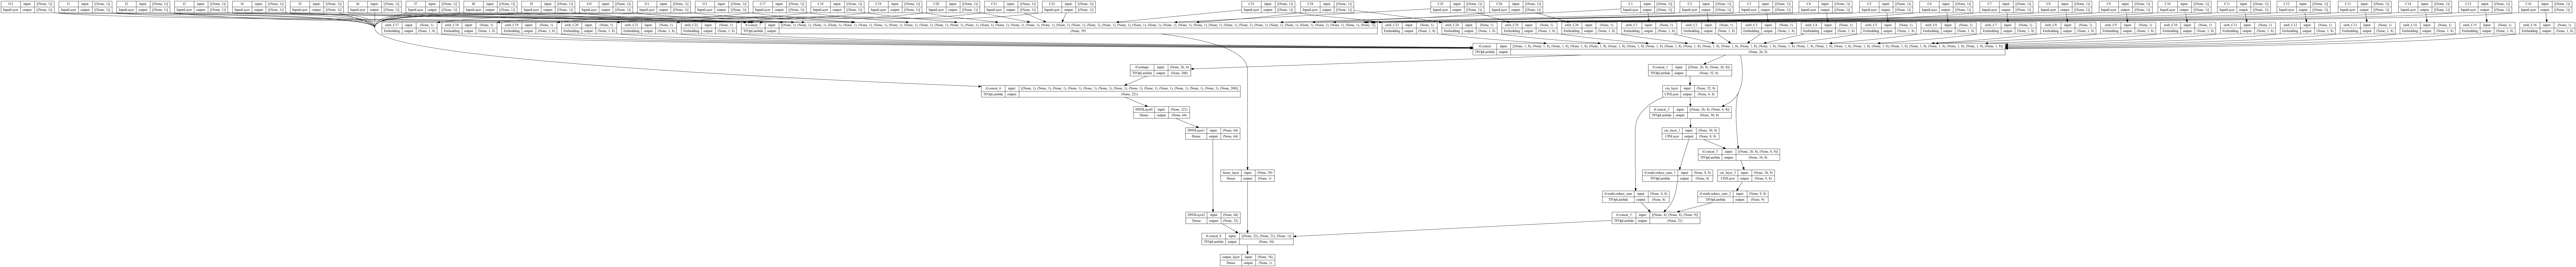

In [14]:
tf.keras.utils.plot_model(model, to_file='./xdeepfm.png', show_shapes=True)

In [15]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 69756), started 5:36:01 ago. (Use '!kill 69756' to kill it.)